In [25]:
!date
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy.special as sps
import arviz as az

import sys
print(sys.version)
print('Running with arviz version v.{}'.format(az.__version__))

from termcolor import colored

%matplotlib inline
# Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Parameters for seaborn plots
import seaborn as sns
clrs = sns.color_palette("Spectral", 6)
def set_plot_style(usetex=False):
    sns.set_style('white', {'axes.linewidth': 0.5})
    sns.set(style='white', font_scale=1.1,#context='paper',
            rc={'xtick.major.size': 6, 'ytick.major.size': 6, 'legend.fontsize': 14,
                'text.usetex': usetex, 'font.family': 'serif', 'font.serif': ['Verdana'],
                'text.latex.preamble': r"\usepackage{type1cm}"}) 
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

func_dict = {"q2.5": lambda x: np.percentile(x, 2.5), 
             "q25": lambda x: np.percentile(x, 25), 
             "median": lambda x: np.percentile(x, 50), 
             "q75": lambda x: np.percentile(x, 75), 
             "q97.5": lambda x: np.percentile(x, 97.5)}

def get_stats(cmdstan_data):
    # include mean and hpd
    stats = az.summary(cmdstan_data,credible_interval=0.95).loc[:, ['mean','hpd_2.5%','hpd_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hpd_2.5%':'hpd2.5', 'hpd_97.5%':'hpd97.5'})
    stats = az.summary(cmdstan_data,credible_interval=0.50).loc[:, ['hpd_25%','hpd_75%']].reset_index().rename(columns={'index':'var', 'hpd_25%':'hpd25', 'hpd_75%':'hpd75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hpd2.5','hpd25','hpd75','hpd97.5','q2.5','q25','median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

Sun May 24 18:30:06 JST 2020
3.6.10 |Anaconda, Inc.| (default, Mar 23 2020, 23:13:11) 
[GCC 7.3.0]
Running with arviz version v.0.7.0


# Model comparison

In [26]:
resultsdir = "../../../Hokkaido_Backup/Taiwan-SI"
dirs = !ls "{resultsdir}"

header = "He"
dirs = [x for x in dirs if header+'-' in x]
dirs

['He-without_exposure-gamma',
 'He-without_exposure-lognormal',
 'He-without_exposure-skew_normal',
 'He-without_exposure-weibull']

In [27]:
%%time
for idx, folder in enumerate(dirs):
    print(colored(folder, 'red'))
    posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
    cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                                   log_likelihood="llk")
    cmdstan_data_all = [cmdstan_data] if idx==0 else np.r_[cmdstan_data_all, cmdstan_data]
    
models = dict([[dirs[idx], cmdstan_data_all[idx]] for idx in range(len(cmdstan_data_all))])
stats_compare = az.compare(models, ic='waic', scale='deviance')
stats_compare

He-without_exposure-gamma
He-without_exposure-lognormal
He-without_exposure-skew_normal
He-without_exposure-weibull
CPU times: user 4 s, sys: 340 ms, total: 4.34 s
Wall time: 4.41 s


/home/aakhmetz/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
He-without_exposure-weibull,0,758.059,24.4104,0,0.838342,16.8718,0,True,deviance
He-without_exposure-gamma,1,762.9,21.1079,4.84179,0.120964,24.3897,2.56003,True,deviance
He-without_exposure-lognormal,2,768.247,24.9315,10.1887,0.0363036,22.8091,5.50084,True,deviance
He-without_exposure-skew_normal,3,798.563,41.9467,40.5048,0.0043907,28.552,11.8399,True,deviance


# Gamma distribution

In [28]:
%%time
folder = [x for x in dirs if 'gamma' in x][0]
print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="llk")

He-without_exposure-gamma
CPU times: user 903 ms, sys: 71.9 ms, total: 974 ms
Wall time: 998 ms


In [29]:
cmdstan_data.posterior

<xarray.Dataset>
Dimensions:                  (Delta_dim_0: 77, SI_raw_dim_0: 77, chain: 4, draw: 2500, xi_dim_0: 77)
Coordinates:
  * chain                    (chain) int64 0 1 2 3
  * draw                     (draw) int64 0 1 2 3 4 ... 2495 2496 2497 2498 2499
  * xi_dim_0                 (xi_dim_0) int64 0 1 2 3 4 5 ... 71 72 73 74 75 76
  * SI_raw_dim_0             (SI_raw_dim_0) int64 0 1 2 3 4 5 ... 72 73 74 75 76
  * Delta_dim_0              (Delta_dim_0) int64 0 1 2 3 4 5 ... 72 73 74 75 76
Data variables:
    mean_infect              (chain, draw) float64 4.492 3.944 ... 4.164 4.478
    sd_infect                (chain, draw) float64 2.718 3.361 ... 3.278 3.272
    c                        (chain, draw) float64 4.039 3.984 ... 3.52 3.794
    xi                       (chain, draw, xi_dim_0) float64 0.4065 ... 0.4983
    SI_raw                   (chain, draw, SI_raw_dim_0) float64 0.9706 ... 0.692
    param1_infect            (chain, draw) float64 2.732 1.377 ... 1.614 1.873
    param2_infect            (chain, draw) float64 0.6082 0.3492 ... 0.4183
    Delta                    (chain, draw, Delta_dim_0) float64 7.98 ... 16.18
    fraction_presymptomatic  (chain, draw) float64 0.5128 0.6176 ... 0.5112
    mode_infect              (chain, draw) float64 -1.191 -2.905 ... -1.707
Attributes:
    created_at:     2020-05-24T09:30:11.751054
    arviz_version:  0.7.0

In [30]:
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['SI_raw', 'Delta', 'xi']))
cmdstan_stats

,var,time,mean,hpd2.5,hpd25,hpd75,hpd97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat
0,mean_infect,NA,4.322,3.290,3.939,4.654,5.404,3.326,3.951,4.300,4.671,5.451,8287.0,7399.0,1.0
1,sd_infect,NA,3.122,2.061,2.636,3.379,4.316,2.122,2.710,3.068,3.472,4.446,4575.0,6255.0,1.0
2,c,NA,3.822,3.364,3.587,3.921,4.349,3.398,3.636,3.793,3.975,4.404,6615.0,5744.0,1.0
3,param1_infect,NA,2.045,0.975,1.476,2.233,3.321,1.079,1.590,1.952,2.384,3.568,2643.0,4485.0,1.0
4,param2_infect,NA,0.479,0.213,0.325,0.506,0.789,0.246,0.369,0.455,0.562,0.859,3280.0,5462.0,1.0
5,fraction_presymptomatic,NA,0.535,0.406,0.491,0.574,0.650,0.413,0.494,0.534,0.577,0.658,8329.0,7858.0,1.0
6,mode_infect,NA,-1.801,-3.185,-2.066,-1.226,-0.573,-3.329,-2.202,-1.745,-1.341,-0.674,3006.0,4583.0,1.0


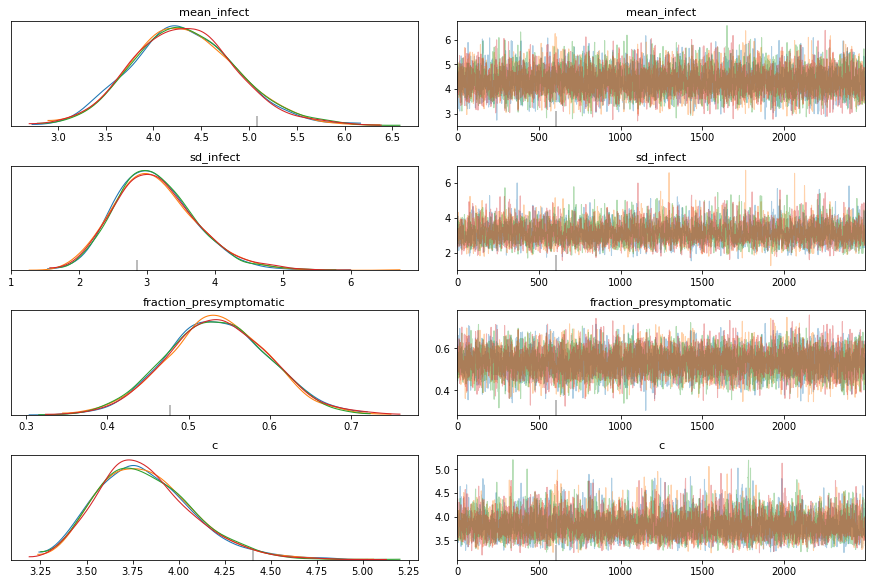

In [31]:
az.plot_trace(cmdstan_data,var_names=['mean_infect', 'sd_infect', 'fraction_presymptomatic', 'c']);

In [32]:
param1 = cmdstan_data.posterior.param1_infect.values.ravel()
param2 = cmdstan_data.posterior.param2_infect.values.ravel()
c = cmdstan_data.posterior.c.values.ravel()

xstep = .01; xmax = 12
x = np.arange(xstep,xmax+xstep,xstep)

nsamples = 2000
gammacdf = lambda x,α,β: sps.gammainc(α,β*x) / sps.gamma(α)
yy = np.stack([[gammacdf(xx+xstep,param1[idx],param2[idx])-gammacdf(xx,param1[idx],param2[idx]) for xx in x] for idx in range(nsamples)]).T

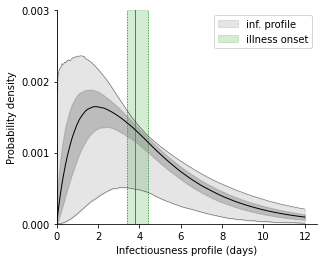

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(4.5,3.5); 

clrs = ['k','C7']

Ymedian = [np.median(yy[j]) for j in range(len(x)-1)]
Ylower = [np.percentile(yy[j],[2.5])[0] for j in range(len(x))]
Yupper = [np.percentile(yy[j],[97.5])[0] for j in range(len(x))]
Y1 = [np.percentile(yy[j],[25])[0] for j in range(len(x))]
Y2 = [np.percentile(yy[j],[75])[0] for j in range(len(x))]
ax.plot(x[1:], Ymedian, lw=1, color=clrs[0])
ax.plot(x, Yupper, lw=.3, color=clrs[0])
ax.plot(x, Ylower, lw=.3, color=clrs[0])
ax.fill_between(x, Ylower, Yupper, color=clrs[1], alpha=.2, label='inf. profile')
ax.fill_between(x, Y1, Y2, color=clrs[1], alpha=.4)
fig.tight_layout();

Cmedian = np.median(c)
Clower = np.percentile(c,[2.5])[0]
Cupper = np.percentile(c,[97.5])[0]
ax.axvline(Cmedian, lw=1, color='C2', linestyle='solid',zorder=-5)
[ax.axvline(y, lw=1, color='C2', linestyle='dotted', zorder=-5) for y in [Clower,Cupper]]
ax.fill_between([Clower, Cupper], 0, 0.003, color='C2', alpha=.2, zorder=-5, label='illness onset')

ax.set_xlabel('Infectiousness profile (days)'); ax.set_ylabel('Probability density')

plt.legend()

ax.set_ylim(bottom=0,top=.003)
ax.set_xlim(left=0)
xtks = np.arange(0,14,2); ax.set_xticks(xtks); 
ytks = [0,.001,.002,.003]; ax.set_yticks(ytks); 
# ax.spines['left'].set_bounds(0,.003)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
ax.axvline(x=0, color='k', ls='dashed', lw=.5);

plt.savefig("../../results/"+header+"-gamma.pdf", format='pdf', bbox_inches='tight');

# Weibull distribution

In [34]:
%%time
folder = [x for x in dirs if 'weibull' in x][0]
print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="llk")

He-without_exposure-weibull
CPU times: user 1.06 s, sys: 108 ms, total: 1.16 s
Wall time: 1.18 s


In [35]:
cmdstan_data.posterior

<xarray.Dataset>
Dimensions:                  (Delta_dim_0: 77, SI_raw_dim_0: 77, chain: 4, draw: 2500, xi_dim_0: 77)
Coordinates:
  * chain                    (chain) int64 0 1 2 3
  * draw                     (draw) int64 0 1 2 3 4 ... 2495 2496 2497 2498 2499
  * xi_dim_0                 (xi_dim_0) int64 0 1 2 3 4 5 ... 71 72 73 74 75 76
  * SI_raw_dim_0             (SI_raw_dim_0) int64 0 1 2 3 4 5 ... 72 73 74 75 76
  * Delta_dim_0              (Delta_dim_0) int64 0 1 2 3 4 5 ... 72 73 74 75 76
Data variables:
    param1_infect            (chain, draw) float64 2.105 2.566 ... 1.634 1.39
    mean_infect              (chain, draw) float64 4.225 4.463 ... 5.171 3.637
    c                        (chain, draw) float64 3.822 3.682 ... 3.848 3.282
    xi                       (chain, draw, xi_dim_0) float64 0.3016 ... 0.247
    SI_raw                   (chain, draw, SI_raw_dim_0) float64 0.5573 ... 0.2641
    param2_infect            (chain, draw) float64 4.77 5.026 ... 5.778 3.986
    Delta                    (chain, draw, Delta_dim_0) float64 6.937 ... 14.81
    fraction_presymptomatic  (chain, draw) float64 0.4661 0.3623 ... 0.5338
    mode_infect              (chain, draw) float64 -0.311 0.4647 ... -1.683
    sd_infect                (chain, draw) float64 2.109 1.866 ... 3.246 2.649
Attributes:
    created_at:     2020-05-24T09:30:34.485002
    arviz_version:  0.7.0

In [36]:
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['SI_raw', 'Delta', 'xi']))
cmdstan_stats

,var,time,mean,hpd2.5,hpd25,hpd75,hpd97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat
0,param1_infect,NA,1.685,1.056,1.347,1.785,2.412,1.128,1.425,1.628,1.884,2.575,1740.0,2795.0,1.0
1,mean_infect,NA,4.070,3.091,3.708,4.371,5.034,3.169,3.727,4.046,4.396,5.124,6216.0,7257.0,1.0
2,c,NA,3.669,3.313,3.498,3.764,4.082,3.338,3.519,3.649,3.793,4.122,7513.0,7036.0,1.0
3,param2_infect,NA,4.513,3.453,4.069,4.813,5.609,3.490,4.126,4.493,4.874,5.658,6547.0,7189.0,1.0
4,fraction_presymptomatic,NA,0.513,0.380,0.458,0.548,0.650,0.381,0.467,0.512,0.557,0.651,7305.0,7378.0,1.0
5,mode_infect,NA,-1.230,-2.853,-1.592,-0.535,0.189,-2.951,-1.745,-1.158,-0.658,0.128,2371.0,4650.0,1.0
6,sd_infect,NA,2.591,1.506,2.072,2.856,3.848,1.556,2.164,2.538,2.960,3.930,2007.0,2900.0,1.0


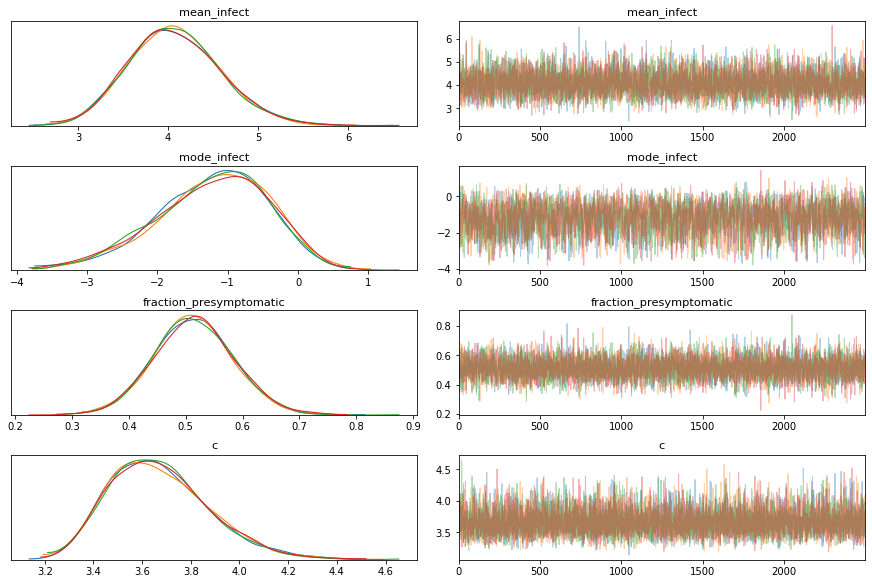

In [37]:
az.plot_trace(cmdstan_data,var_names=['mean_infect', 'mode_infect', 'fraction_presymptomatic', 'c']);

In [38]:
param1 = cmdstan_data.posterior.param1_infect.values.ravel()
param2 = cmdstan_data.posterior.param2_infect.values.ravel()
c = cmdstan_data.posterior.c.values.ravel()

xstep = .01; xmax = 12
x = np.arange(xstep,xmax+xstep,xstep)

nsamples = 10000
weibullcdf = lambda x,k,θ: -np.expm1(-(x/θ)**k)
yy = np.stack([[weibullcdf(xx,param1[idx],param2[idx])-weibullcdf(xx-xstep,param1[idx],param2[idx]) for xx in x] for idx in range(nsamples)]).T

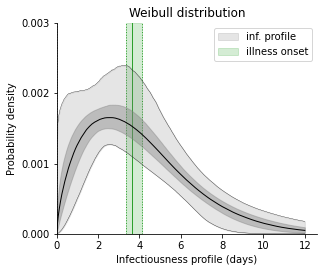

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(4.5,3.5); 

clrs = ['k','C7']

Ymedian = [np.median(yy[j]) for j in range(len(x)-1)]
Ylower = [np.percentile(yy[j],[2.5])[0] for j in range(len(x))]
Yupper = [np.percentile(yy[j],[97.5])[0] for j in range(len(x))]
Y1 = [np.percentile(yy[j],[25])[0] for j in range(len(x))]
Y2 = [np.percentile(yy[j],[75])[0] for j in range(len(x))]
ax.plot(x[1:], Ymedian, lw=1, color=clrs[0])
ax.plot(x, Yupper, lw=.3, color=clrs[0])
ax.plot(x, Ylower, lw=.3, color=clrs[0])
ax.fill_between(x, Ylower, Yupper, color=clrs[1], alpha=.2, label='inf. profile')
ax.fill_between(x, Y1, Y2, color=clrs[1], alpha=.4)
fig.tight_layout();

Cmedian = np.median(c)
Clower = np.percentile(c,[2.5])[0]
Cupper = np.percentile(c,[97.5])[0]
ax.axvline(Cmedian, lw=1, color='C2', linestyle='solid',zorder=-5)
[ax.axvline(y, lw=1, color='C2', linestyle='dotted', zorder=-5) for y in [Clower,Cupper]]
ax.fill_between([Clower, Cupper], 0, 0.003, color='C2', alpha=.2, zorder=-5, label='illness onset')

ax.set_xlabel('Infectiousness profile (days)'); ax.set_ylabel('Probability density')
ax.set_title("Weibull distribution")

plt.legend()

ax.set_ylim(bottom=0,top=.003)
ax.set_xlim(left=0)
xtks = np.arange(0,14,2); ax.set_xticks(xtks); 
ytks = [0,.001,.002,.003]; ax.set_yticks(ytks); 
# ax.spines['left'].set_bounds(0,.003)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
ax.axvline(x=0, color='k', ls='dashed', lw=.5);

plt.savefig("../../results/"+header+"-weibull.pdf", format='pdf', bbox_inches='tight');

# Lognormal distribution

In [40]:
%%time
folder = [x for x in dirs if 'lognormal' in x][0]
print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="llk")

He-without_exposure-lognormal
CPU times: user 902 ms, sys: 60 ms, total: 962 ms
Wall time: 986 ms


In [41]:
cmdstan_data.posterior

<xarray.Dataset>
Dimensions:                  (Delta_dim_0: 77, SI_raw_dim_0: 77, chain: 4, draw: 2500, xi_dim_0: 77)
Coordinates:
  * chain                    (chain) int64 0 1 2 3
  * draw                     (draw) int64 0 1 2 3 4 ... 2495 2496 2497 2498 2499
  * xi_dim_0                 (xi_dim_0) int64 0 1 2 3 4 5 ... 71 72 73 74 75 76
  * SI_raw_dim_0             (SI_raw_dim_0) int64 0 1 2 3 4 5 ... 72 73 74 75 76
  * Delta_dim_0              (Delta_dim_0) int64 0 1 2 3 4 5 ... 72 73 74 75 76
Data variables:
    logmean_infect           (chain, draw) float64 1.366 1.631 ... 1.269 1.34
    logsd_infect             (chain, draw) float64 1.049 1.669 ... 1.086 1.496
    c                        (chain, draw) float64 3.735 3.772 ... 3.841 3.657
    xi                       (chain, draw, xi_dim_0) float64 0.6294 ... 0.1165
    SI_raw                   (chain, draw, SI_raw_dim_0) float64 0.7757 ... 0.973
    param2_infect            (chain, draw) float64 0.6522 0.8556 ... 0.9282
    param1_infect            (chain, draw) float64 1.153 1.264 ... 1.006 0.9089
    Delta                    (chain, draw, Delta_dim_0) float64 7.286 ... 16.6
    mean_infect              (chain, draw) float64 3.92 5.106 ... 3.557 3.818
    sd_infect                (chain, draw) float64 2.854 5.305 ... 2.962 4.463
    fraction_presymptomatic  (chain, draw) float64 0.5994 0.5295 ... 0.662
    mode_infect              (chain, draw) float64 -1.664 -2.069 ... -2.609
Attributes:
    created_at:     2020-05-24T09:31:32.427175
    arviz_version:  0.7.0

In [42]:
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['SI_raw', 'Delta', 'xi']))
cmdstan_stats

,var,time,mean,hpd2.5,hpd25,hpd75,hpd97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat
0,logmean_infect,NA,1.402,1.124,1.310,1.492,1.669,1.125,1.311,1.403,1.493,1.670,6367.0,6530.0,1.0
1,logsd_infect,NA,1.280,0.797,1.118,1.441,1.768,0.820,1.111,1.268,1.436,1.803,4897.0,6287.0,1.0
2,c,NA,3.776,3.383,3.596,3.875,4.194,3.421,3.623,3.752,3.904,4.253,7039.0,6057.0,1.0
3,param2_infect,NA,0.765,0.554,0.664,0.812,0.998,0.562,0.685,0.757,0.835,1.008,3361.0,5427.0,1.0
4,param1_infect,NA,1.103,0.774,1.008,1.221,1.399,0.765,0.999,1.112,1.213,1.394,4097.0,5517.0,1.0
5,mean_infect,NA,4.101,2.992,3.683,4.422,5.202,3.081,3.709,4.067,4.452,5.313,6367.0,6530.0,1.0
6,sd_infect,NA,3.712,2.044,2.808,3.909,5.586,2.271,3.039,3.553,4.205,6.070,4897.0,6287.0,1.0
7,fraction_presymptomatic,NA,0.612,0.484,0.569,0.656,0.734,0.485,0.569,0.613,0.656,0.735,6199.0,7083.0,1.0
8,mode_infect,NA,-2.050,-2.782,-2.351,-1.813,-1.262,-2.788,-2.324,-2.052,-1.783,-1.264,3834.0,5783.0,1.0


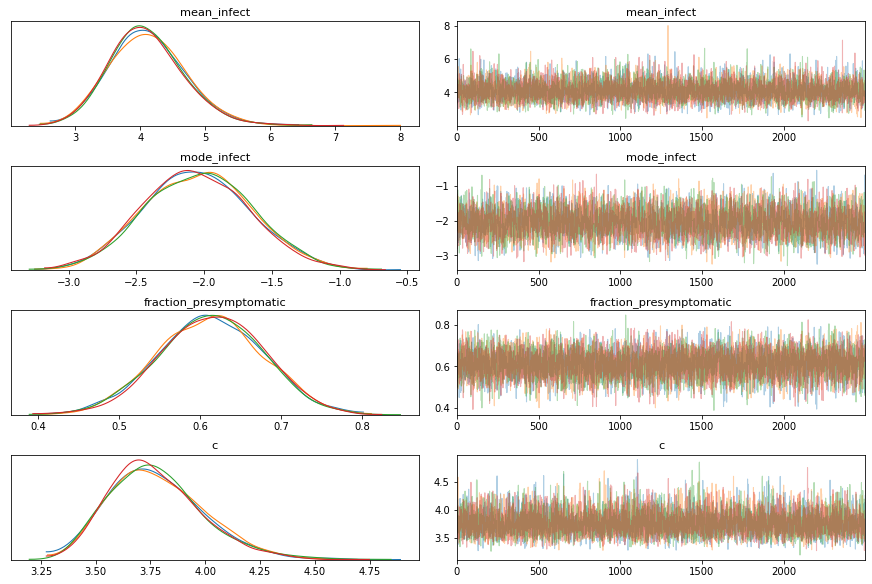

In [43]:
az.plot_trace(cmdstan_data,var_names=['mean_infect', 'mode_infect', 'fraction_presymptomatic', 'c']);

In [44]:
param1 = cmdstan_data.posterior.param1_infect.values.ravel()
param2 = cmdstan_data.posterior.param2_infect.values.ravel()
c = cmdstan_data.posterior.c.values.ravel()

xstep = .01; xmax = 12
x = np.arange(xstep,xmax+xstep,xstep)

nsamples = 3000
# a bit faster than to use scipy.stats functions
lognormalcdf = lambda x,mu,sigma: 0.5 + 0.5*sps.erf((np.log(x)-mu)/np.sqrt(2.0)/sigma)
yy = np.stack([[lognormalcdf(xx,param1[idx],param2[idx])-lognormalcdf(xx-xstep,param1[idx],param2[idx]) for xx in x] for idx in range(nsamples)]).T

/home/aakhmetz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


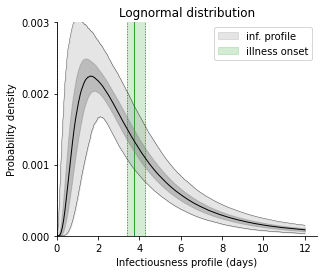

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(4.5,3.5); 

clrs = ['k','C7']

Ymedian = [np.median(yy[j]) for j in range(len(x)-1)]
Ylower = [np.percentile(yy[j],[2.5])[0] for j in range(len(x))]
Yupper = [np.percentile(yy[j],[97.5])[0] for j in range(len(x))]
Y1 = [np.percentile(yy[j],[25])[0] for j in range(len(x))]
Y2 = [np.percentile(yy[j],[75])[0] for j in range(len(x))]
ax.plot(x[1:], Ymedian, lw=1, color=clrs[0])
ax.plot(x, Yupper, lw=.3, color=clrs[0])
ax.plot(x, Ylower, lw=.3, color=clrs[0])
ax.fill_between(x, Ylower, Yupper, color=clrs[1], alpha=.2, label='inf. profile')
ax.fill_between(x, Y1, Y2, color=clrs[1], alpha=.4)
fig.tight_layout();

Cmedian = np.median(c)
Clower = np.percentile(c,[2.5])[0]
Cupper = np.percentile(c,[97.5])[0]
ax.axvline(Cmedian, lw=1, color='C2', linestyle='solid',zorder=-5)
[ax.axvline(y, lw=1, color='C2', linestyle='dotted', zorder=-5) for y in [Clower,Cupper]]
ax.fill_between([Clower, Cupper], 0, 0.01, color='C2', alpha=.2, zorder=-5, label='illness onset')

ax.set_xlabel('Infectiousness profile (days)'); ax.set_ylabel('Probability density')
ax.set_title("Lognormal distribution")

plt.legend()

ymax = 0.003
ax.set_ylim(bottom=0, top=ymax)
ax.set_xlim(left=0)
xtks = np.arange(0,14,2); ax.set_xticks(xtks); 
ytks = [0,.001,.002,.003]; ax.set_yticks(ytks); 
# ax.spines['left'].set_bounds(0,.003)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
ax.axvline(x=0, color='k', ls='dashed', lw=.5);

plt.savefig("../../results/"+header+"-lognormal.pdf", format='pdf', bbox_inches='tight');

# Skew normal

In [46]:
%%time
folder = [x for x in dirs if 'skew' in x][0]
print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], log_likelihood="llk")

He-without_exposure-skew_normal
CPU times: user 1.13 s, sys: 92.1 ms, total: 1.22 s
Wall time: 1.25 s


In [47]:
cmdstan_data.posterior

<xarray.Dataset>
Dimensions:                  (chain: 4, draw: 1250, o1_dim_0: 77, o1_raw_dim_0: 77, o2_dim_0: 77, o2_raw_dim_0: 77, tI_dim_0: 77, tI_raw_dim_0: 77)
Coordinates:
  * chain                    (chain) int64 0 1 2 3
  * draw                     (draw) int64 0 1 2 3 4 ... 1245 1246 1247 1248 1249
  * tI_raw_dim_0             (tI_raw_dim_0) int64 0 1 2 3 4 5 ... 72 73 74 75 76
  * o1_raw_dim_0             (o1_raw_dim_0) int64 0 1 2 3 4 5 ... 72 73 74 75 76
  * o2_raw_dim_0             (o2_raw_dim_0) int64 0 1 2 3 4 5 ... 72 73 74 75 76
  * tI_dim_0                 (tI_dim_0) int64 0 1 2 3 4 5 ... 71 72 73 74 75 76
  * o1_dim_0                 (o1_dim_0) int64 0 1 2 3 4 5 ... 71 72 73 74 75 76
  * o2_dim_0                 (o2_dim_0) int64 0 1 2 3 4 5 ... 71 72 73 74 75 76
Data variables:
    xi_infect                (chain, draw) float64 2.074 2.269 ... 1.277 0.9276
    omega_infect             (chain, draw) float64 3.5 3.494 ... 2.166 2.615
    alpha_infect             (chain, draw) float64 -1.331 -1.101 ... -1.933
    tI_raw                   (chain, draw, tI_raw_dim_0) float64 0.7925 ... 0.2887
    o1_raw                   (chain, draw, o1_raw_dim_0) float64 0.4832 ... 0.6021
    o2_raw                   (chain, draw, o2_raw_dim_0) float64 0.1411 ... 0.5358
    tI                       (chain, draw, tI_dim_0) float64 -1.217 ... -2.401
    o1                       (chain, draw, o1_dim_0) float64 0.4832 ... 0.6021
    o2                       (chain, draw, o2_dim_0) float64 3.141 ... 12.54
    mean_infect              (chain, draw) float64 -0.1583 0.2055 ... -0.9257
    sd_infect                (chain, draw) float64 2.695 2.819 ... 1.62 1.845
    skewness_infect          (chain, draw) float64 -0.2439 -0.1683 ... -0.435
    fraction_presymptomatic  (chain, draw) float64 0.5066 0.4593 ... 0.6733
Attributes:
    created_at:     2020-05-24T09:32:08.526000
    arviz_version:  0.7.0

In [48]:
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['o1_raw','o2_raw','tI_raw', 'tI', 'o1', 'o2',
                                                       'xi_infect', 'omega_infect', 'alpha_infect']))
cmdstan_stats

,var,time,mean,hpd2.5,hpd25,hpd75,hpd97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat
0,mean_infect,NA,0.104,-0.841,-0.205,0.445,1.098,-0.832,-0.230,0.090,0.423,1.113,2200.0,3168.0,1.0
1,sd_infect,NA,2.549,1.564,2.084,2.738,3.514,1.660,2.195,2.521,2.861,3.622,861.0,1431.0,1.0
2,skewness_infect,NA,-0.032,-0.492,-0.071,0.052,0.376,-0.481,-0.104,-0.001,0.029,0.392,1335.0,2512.0,1.0
3,fraction_presymptomatic,NA,0.487,0.338,0.425,0.525,0.635,0.347,0.435,0.483,0.535,0.649,2242.0,3059.0,1.0


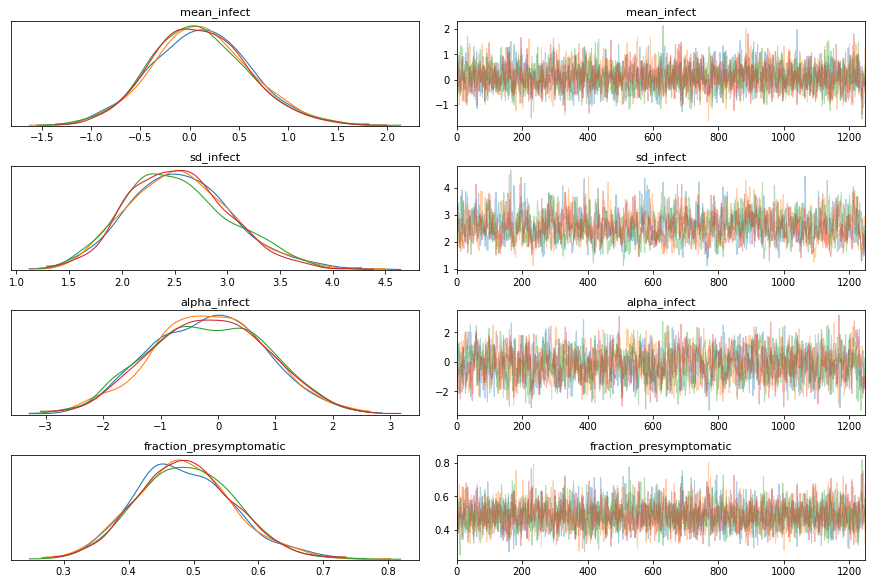

In [49]:
az.plot_trace(cmdstan_data,var_names=['mean_infect', 'sd_infect', 'alpha_infect', 'fraction_presymptomatic']);

In [50]:
param1 = cmdstan_data.posterior.xi_infect.values.ravel()
param2 = cmdstan_data.posterior.omega_infect.values.ravel()
param3 = cmdstan_data.posterior.omega_infect.values.ravel()

xstep = .01; xmax = 12
x = np.arange(-4.0+xstep,xmax+xstep,xstep)

nsamples = 4000
skewnormalcdf = lambda x, xi, omega, alpha: 0.5*(1.0 + sps.erf((x-xi)/omega/np.sqrt(2))) - 2.0*sps.owens_t((x-xi)/omega, alpha)
yy = np.stack([[skewnormalcdf(xx+xstep,param1[idx],param2[idx],param3[idx])-skewnormalcdf(xx,param1[idx],param2[idx],param3[idx]) for xx in x] for idx in range(nsamples)]).T

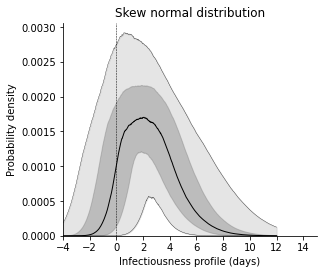

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches(4.5,3.5); 

clrs = ['k','C7']

Ymedian = [np.median(yy[j]) for j in range(len(x)-1)]
Ylower = [np.percentile(yy[j],[2.5])[0] for j in range(len(x))]
Yupper = [np.percentile(yy[j],[97.5])[0] for j in range(len(x))]
Y1 = [np.percentile(yy[j],[25])[0] for j in range(len(x))]
Y2 = [np.percentile(yy[j],[75])[0] for j in range(len(x))]
ax.plot(x[1:], Ymedian, lw=1, color=clrs[0])
ax.plot(x, Yupper, lw=.3, color=clrs[0])
ax.plot(x, Ylower, lw=.3, color=clrs[0])
ax.fill_between(x, Ylower, Yupper, color=clrs[1], alpha=.2)
ax.fill_between(x, Y1, Y2, color=clrs[1], alpha=.4)
fig.tight_layout();

ax.set_xlabel('Infectiousness profile (days)'); ax.set_ylabel('Probability density')
ax.set_title("Skew normal distribution")

ax.set_ylim(bottom=0)
ax.set_xlim(-4, 15)
xtks = np.arange(-4,15,2); ax.set_xticks(xtks); 
# ytks = [0,.001,.002,.003]; ax.set_yticks(ytks); 
# ax.spines['left'].set_bounds(0,.003)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
ax.axvline(x=0, color='k', ls='dashed', lw=.5);

plt.savefig("../../results/"+header+"-skew_normal.pdf", format='pdf', bbox_inches='tight');